In [1]:
import sys
sys.path.append("/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/_scripts")

from svg_reader import SVGReader
from adjacencies.adjacency import AdjacencyGenerator
from adjacencies.connectivity import ConnectivityGenerator

In [2]:
svg_name = "amber_building_a_f01.svg"
sv = SVGReader(svg_name)
sv.run()

In [3]:
ag = AdjacencyGenerator(sv.domains)
ag.run()

In [4]:
cg = ConnectivityGenerator(ag.positioned_graph)
cg.run()

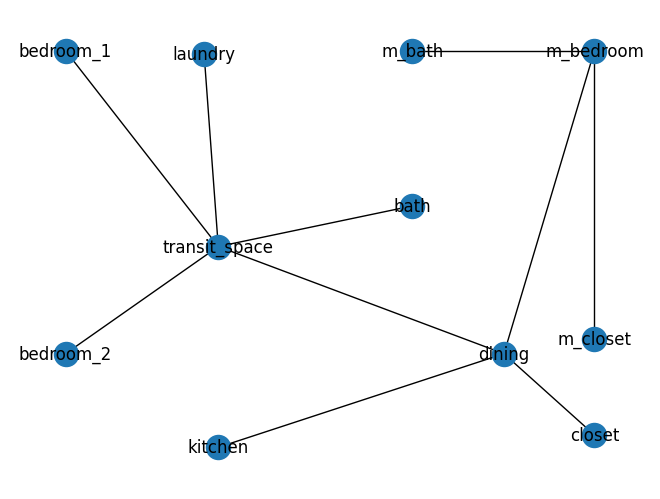

In [6]:
cg.draw_graph()

In [7]:
# some tests ...
# transit space has 5 links 
# mbed is connected to m_closet and m_bath

def test_edge(e):
    return frozenset(e) in [frozenset(v.edge) for v in cg.conn.values()]
 
def test_transit_space(conn):
    n_expected = 5
    counter = 0
    nbs = []
    for k, v in conn.items():
        if v.is_linked and "transit_space" in v.edge:
            nbs.append(v.edge)
            counter+=1
    if counter != n_expected:
        print(f"neighbors: {[sorted(n) for n in nbs]}")
        raise Exception("Edge test failed")
    
def test_m_bedroom():
    for room in ["bath", "m_closet"]:
        assert test_edge((room, "m_bedroom"))
        
        
test_transit_space(cg.conn)
test_m_bedroom()